In [144]:
from collections import Counter
from concurrent.futures import ThreadPoolExecutor, as_completed
from io import BytesIO
import os
import warnings

import cv2
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image, ImageOps
import pandas as pd
import requests
from scipy.ndimage import label
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

from era_data import TabletPeriodDataset, get_IDS, pad_zeros

# Ignore specific FutureWarnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='seaborn')

In [2]:
IMG_DIR = 'output/images_preprocessed'

IDS = get_IDS(IMG_DIR=IMG_DIR)
len(IDS)

94936

In [3]:
image_names = [os.path.splitext(file)[0] for file in os.listdir(IMG_DIR) if file.endswith('.png')]

In [4]:
df = pd.read_csv('output/cdli_catalogue_data.csv')

In [5]:
df['id_text_normed']=[pad_zeros(x) for x in df['id_text']]

In [6]:
df = df[df['id_text_normed'].isin(image_names)]

In [7]:
df=df[(df['period_normed'].isin(TabletPeriodDataset.PERIOD_INDICES))&(df['era'].notnull())]

In [8]:
train_ids, test_ids = train_test_split(IDS, test_size=500, random_state=0)
len(train_ids), len(test_ids)

(94436, 500)

In [9]:
train_ids, val_ids = train_test_split(train_ids, test_size=500, random_state=0)
len(train_ids), len(val_ids)

(93936, 500)

In [10]:
ds_train = TabletPeriodDataset(IDS=train_ids, IMG_DIR=IMG_DIR, mask=True)
ds_val = TabletPeriodDataset(IDS=val_ids, IMG_DIR=IMG_DIR, mask=True)
ds_test = TabletPeriodDataset(IDS=test_ids, IMG_DIR=IMG_DIR, mask=True)

Filtering 94936 IDS down to provided 93936...
Filtering 94936 IDS down to provided 500...
Filtering 94936 IDS down to provided 500...


In [11]:
def tablet_biggest_comp(binary_image):

    # Find connected components
    labeled_image, num_features = label(binary_image)

    # Calculate the sizes of the connected components
    component_sizes = np.bincount(labeled_image.ravel())

    # Find the label of the largest component (excluding background)
    largest_component_label = np.argmax(component_sizes[1:]) + 1

    # Create a mask for the largest component
    largest_component_mask = (labeled_image == largest_component_label)

    # Extract the largest component using the mask
    largest_component_image = binary_image * largest_component_mask

    return largest_component_image

def tablet_h_w_ratio(image):
    # Find contours in the binary image
    contours, _ = cv2.findContours(image.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Find the largest contour (object)
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate the bounding box of the largest contour
    x, y, w, h = cv2.boundingRect(largest_contour)

    # Calculate width and height
    width = w
    height = h
    return (h, w, round(height / width, 2))

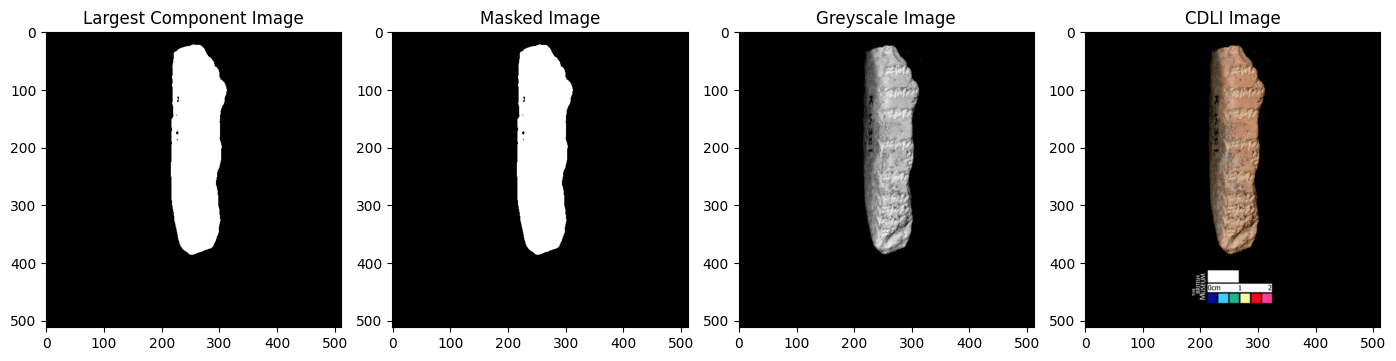

CDLI ID: 400770


In [178]:
id_img = 71748

plt.figure(figsize=(14, 5))  

# Process and display the largest component image
image = ds_train[id_img][1]
largest_component_image = tablet_biggest_comp(image)
plt.subplot(1, 4, 1)
plt.imshow(largest_component_image, cmap='gray')
plt.title('Largest Component Image')

# Display the masked image
plt.subplot(1, 4, 2)
plt.imshow(image, cmap='gray')
plt.title('Masked Image')

# Display the greyscale image
plt.subplot(1, 4, 3)
plt.imshow(Image.open(ds_train.img_fns[id_img]), cmap='gray')
plt.title('Greyscale Image')

# Construct URL and download the fourth image using the CDLI ID
cdli_id = ds_train[id_img][0]  # Extract the CDLI ID from your dataset
url = f"https://cdli.ucla.edu/dl/photo/P{cdli_id}.jpg"
response = requests.get(url)
fourth_image = Image.open(BytesIO(response.content))

# Resize the scraped image to 512x512 while keeping the aspect ratio
target_size = (512, 512)
fourth_image.thumbnail(target_size, Image.LANCZOS)
# Create a black background
background = Image.new("RGB", target_size, "black")
# Calculate the position to paste the resized image on the background
background.paste(fourth_image, (int((target_size[0] - fourth_image.width) / 2), int((target_size[1] - fourth_image.height) / 2)))

# Display the CDLI image
plt.subplot(1, 4, 4)
plt.imshow(background, cmap='gray')
plt.title('CDLI Image')

plt.tight_layout()
plt.show()

# Printing the CDLI ID
print("CDLI ID: " + cdli_id)


In [167]:
# Print the calculated width and height
image = ds_train[id_img][1]
largest_component_image = tablet_biggest_comp(image)
print("Ratio (Height/Width):", tablet_h_w_ratio(largest_component_image))

Ratio (Height/Width): (195, 141, 1.38)


In [16]:
def calculate_ratio_and_extract_values(tablet_id):
    biggest_component = tablet_biggest_comp(ds_train[tablet_id][1])
    h, w, ratio = tablet_h_w_ratio(biggest_component)
    values = [ds_train[tablet_id][2], ds_train[tablet_id][3]]  # Extract additional values
    return {'tablet_id': tablet_id, 'height': h, 'width': w, 'hw_ratio': ratio, 'period': values[0], 'genre': values[1]}

# Function to execute in parallel
def process_tablet_id(tablet_id):
    return calculate_ratio_and_extract_values(tablet_id)

# Prepare to accumulate results
data = []

# Number of workers (threads); adjust based on your hardware
num_workers = 6

# Initialize ThreadPoolExecutor
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    # Create a list to hold the futures
    futures = [executor.submit(process_tablet_id, tablet_id) for tablet_id in range(0, len(train_ids))]
    
    # Initialize tqdm progress bar
    progress = tqdm(as_completed(futures), total=len(futures), desc='Processing Tablets')
    
    for future in progress:
        # As each future completes, append its result to the data list
        data.append(future.result())

# Convert the list of dictionaries to a DataFrame
ratio_df = pd.DataFrame(data)

# Print the resulting DataFrame
ratio_df.to_csv('output/ratio_df.csv', index = False) 

Processing Tablets:   0%|          | 0/93936 [00:00<?, ?it/s]

In [17]:
PERIOD_INDICES = {

    0: 'other',
    1: 'Ur III',
    2: 'Neo-Assyrian',
    3: 'Old Babylonian',
    4: 'Middle Babylonian',
    5: 'Neo-Babylonian',
    6: 'Old Akkadian',
    7: 'Achaemenid',
    8: 'Early Old Babylonian',
    9: 'ED IIIb',
    10: 'Middle Assyrian',
    11: 'Old Assyrian',
    12: 'Uruk III',
    13: 'Proto-Elamite',
    14: 'Lagash II',
    15: 'Ebla',
    16: 'ED IIIa',
    17: 'Hellenistic',
    18: 'ED I-II',
    19: 'Middle Elamite',
    20: 'Middle Hittite',
    21: 'Uruk IV'
}

GENRE_INDICES = {
        
        1: 'Administrative',
        2: 'Letter',
        3: 'Legal',
        4: 'Royal/Monumental',
        5: 'Literary',
        6: 'Lexical',
        7: 'Omen',
        8: 'uncertain',
        9: 'School',
        10: 'Mathematical',
        11: 'Prayer/Incantation',
        12: 'Scientific',
        13: 'Ritual',
        14: 'fake (modern)',
        15: 'Astronomical',
        16: 'Private/Votive',
    }

ratio_df['Period_Name'] = ratio_df['period'].map(PERIOD_INDICES)
ratio_df['Genre_Name'] = ratio_df['genre'].map(GENRE_INDICES)

In [18]:
def period_to_millennium(period):
    if period in ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                                                                         'Ur III']:
        return "3rd millennium BCE"
    elif period in ['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                                                                        'Middle Babylonian', 'Middle Elamite', 'Middle Hittite']:
        return "2nd millennium BCE"
    else:
        return "1st millennium BCE"

# Apply the function to the 'period' column to create a new 'millennium' column
ratio_df['millennium'] = ratio_df['Period_Name'].apply(period_to_millennium)


In [19]:
ratio_df.to_csv('output/ratio_df.csv', index = False) 

In [20]:
ratio_df = pd.read_csv('output/ratio_df.csv')

In [182]:
ratio_df[ratio_df['hw_ratio']<0.6].Period_Name.value_counts()

Period_Name
Neo-Assyrian            1583
Old Babylonian           571
Lagash II                343
Neo-Babylonian           334
Early Old Babylonian     325
Ur III                   234
Middle Babylonian        196
Old Akkadian             106
Achaemenid               101
ED IIIb                   81
Middle Elamite            79
Middle Assyrian           77
Old Assyrian              55
other                     38
Proto-Elamite             35
Uruk III                  17
Ebla                      16
Hellenistic               13
ED I-II                    7
ED IIIa                    4
Middle Hittite             4
Name: count, dtype: int64

In [183]:
plt.figure(figsize=(5, 3))
box_p = sns.boxplot(y = 'millennium', x = 'hw_ratio', data = ratio_df[ratio_df['hw_ratio']<9])
left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15);
#plt.show() 
box_pdf_path = 'output/plots/hr_per_mill_box.pdf'
plt.savefig(box_pdf_path, format='pdf')
plt.close()  


plt.figure(figsize=(5, 3))
dist_p = sns.kdeplot(hue = 'millennium', x = 'hw_ratio', data = ratio_df[ratio_df['hw_ratio']<9])
left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.yticks(fontsize=10)
plt.title('Height/Width Ratio per Millennium', size=15);
kde_pdf_path = 'output/plots/hr_per_mill_kde.pdf'
plt.savefig(kde_pdf_path, format='pdf')
plt.close()  

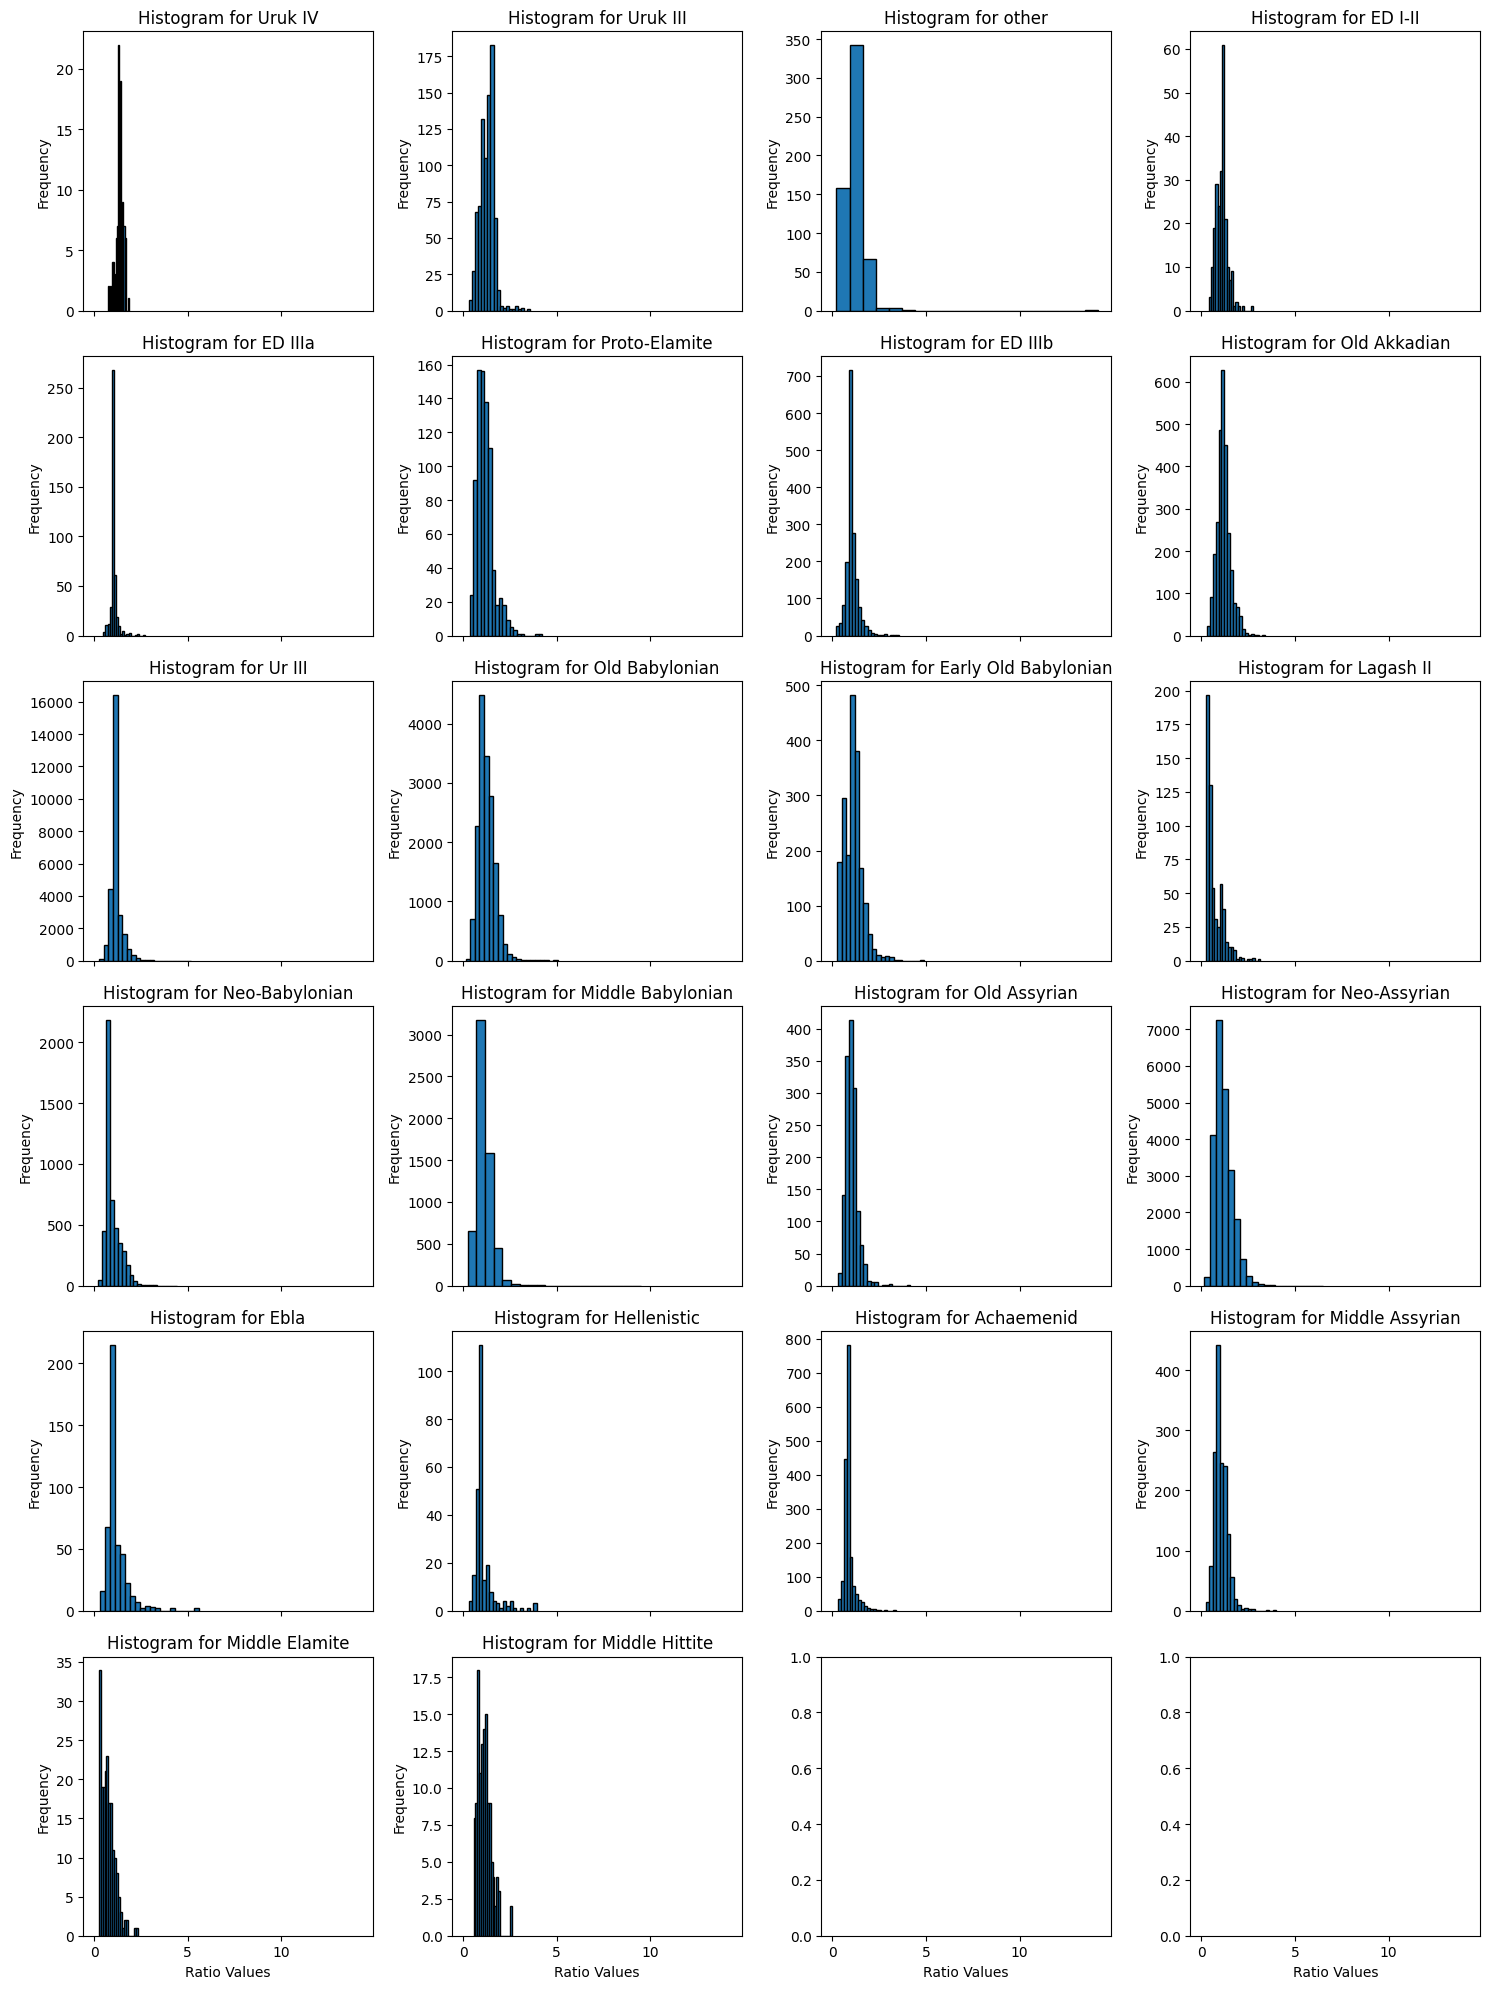

In [24]:
num_periods = ratio_df.period.nunique()
num_cols = 4  
num_rows = -(-num_periods // num_cols)  

fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 20), sharex=True)  # Add 'sharex=True'

for idx, period in enumerate(ratio_df.Period_Name.unique()):
    row = idx // num_cols
    col = idx % num_cols
    period_df = ratio_df[ratio_df['Period_Name']==period]
    # Create histogram in the specified subplot
    axs[row, col].hist(period_df['hw_ratio'], bins=20, edgecolor='black')
    axs[row, col].set_title(f'Histogram for {period}')
    axs[row, col].set_ylabel('Frequency')

for ax in axs[-1, :]:
    ax.set_xlabel('Ratio Values')

plt.tight_layout()
plt.show()

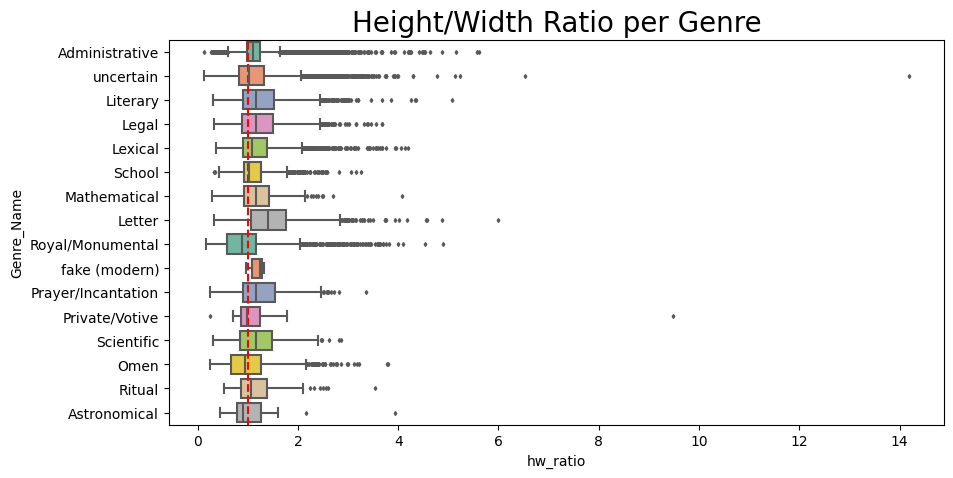

In [49]:
plt.figure(figsize=(10,5))

box_p = sns.boxplot(y='Genre_Name', x='hw_ratio', data=ratio_df, 
                    palette="Set2", fliersize=2)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
plt.title('Height/Width Ratio per Genre', size=20)

plt.show()


In [220]:
plt.figure(figsize=(10,5))

period_order = ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Middle Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

millennium_order = ['3rd millennium BCE', '2nd millennium BCE', '1st millennium BCE']

period_index = {period: i for i, period in enumerate(period_order)}
ratio_df['Period_Index'] = ratio_df['Period_Name'].map(period_index)

box_p = sns.boxplot(y='Period_Name', x='hw_ratio', data= ratio_df[ratio_df['hw_ratio']<9], hue='millennium', hue_order=millennium_order,
                    order=period_order, fliersize=2, dodge=False)

left, right = plt.ylim()
plt.vlines([1], ymin=left, ymax=right, color='yellow', linestyles='--', linewidth=3)
plt.title('Height/Width Ratio per Period', size=20)
plt.legend(title='Millennium', bbox_to_anchor=(1.05, 1), loc='upper left')

box_pdf_path = 'output/plots/hr_per_period_box.pdf'
plt.savefig(box_pdf_path, format='pdf')
plt.close()  
#plt.show()


In [229]:
for millennium in ratio_df["millennium"].unique():
    if millennium == "1st millennium BCE":
        period_order=['Neo-Assyrian', 'Neo-Babylonian', 'Achaemenid', 'Hellenistic']

    elif millennium == "2nd millennium BCE":
        period_order=['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Middle Hittite']
    else:
        period_order=['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
        'Ur III']
    
    plt.figure(figsize=(5, 3))
    box_p = sns.boxplot(y = 'Period_Name', x = 'hw_ratio', data = ratio_df[(ratio_df["millennium"]==millennium)&(ratio_df["Period_Name"]!='other')&(ratio_df['hw_ratio']<9)], 
                        order=period_order, fliersize=1.5)
    left, right = plt.ylim()
    plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')
    plt.yticks(fontsize=10)
    plt.title('Height/Width Ratio per Period -' + millennium, size=11);
    plt.savefig('output/plots/hr_per_period_in_mill_box'+millennium+'.pdf', format='pdf')
    plt.close()  

In [28]:
ratio_df[['height', 'width','Genre_Name']].groupby('Genre_Name').corr().unstack().iloc[:,1].sort_values()

Genre_Name
Private/Votive       -0.152864
School                0.201771
Legal                 0.353083
Astronomical          0.362460
Scientific            0.406174
Administrative        0.421792
Literary              0.448105
Lexical               0.502123
fake (modern)         0.506496
Ritual                0.535826
Prayer/Incantation    0.539213
Letter                0.627885
Royal/Monumental      0.630248
uncertain             0.650084
Mathematical          0.658042
Omen                  0.673243
Name: (height, width), dtype: float64

In [29]:
ratio_df[['height', 'width','Period_Name']].groupby('Period_Name').corr().unstack().iloc[:,1].sort_values()

Period_Name
Middle Babylonian       0.094238
Proto-Elamite           0.117135
Hellenistic             0.210703
Uruk III                0.232223
Old Babylonian          0.290198
Achaemenid              0.313309
Old Assyrian            0.346008
Lagash II               0.349167
Middle Elamite          0.404498
Middle Assyrian         0.404636
Ur III                  0.428552
other                   0.432952
Early Old Babylonian    0.508261
Middle Hittite          0.531630
ED IIIb                 0.556389
Neo-Babylonian          0.590253
ED I-II                 0.591853
Old Akkadian            0.643955
Ebla                    0.658779
ED IIIa                 0.674268
Uruk IV                 0.695604
Neo-Assyrian            0.706100
Name: (height, width), dtype: float64

In [30]:
ratio_df[ratio_df['millennium']=='1st millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.674244
width,0.674244,1.000000


In [31]:
ratio_df[ratio_df['millennium']=='2nd millennium BCE'][['height', 'width']].corr()

,height,width
height,1.000000,0.317771
width,0.317771,1.000000


In [32]:
ratio_df[(ratio_df['millennium']=='3rd millennium BCE')&(ratio_df['period']!="other")][['height', 'width']].corr()

,height,width
height,1.000000,0.515525
width,0.515525,1.000000


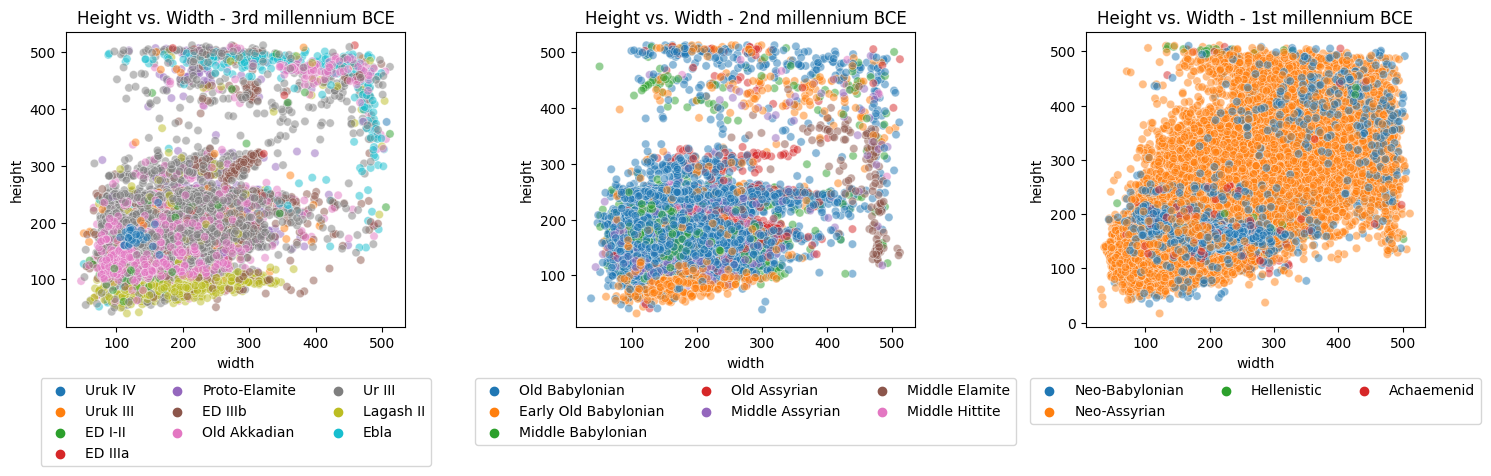

In [33]:
unique_millenniums = ratio_df[ratio_df["Period_Name"] != 'other']["millennium"].unique()

fig, axes = plt.subplots(1, len(unique_millenniums), figsize=(15, 5))  # Adjust the figsize based on the number of millenniums

for i, millennium in enumerate(unique_millenniums):
    ax = axes[i]
    plot = sns.scatterplot(x='width', y='height', hue='Period_Name', 
                    data=ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Period_Name"] != 'other')],
                    alpha=0.5, ax=ax)
    
    ax.set_title("Height vs. Width - " + millennium)

    # Place a legend below each subplot
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)

# Adjust the layout
plt.tight_layout()

plt.show()


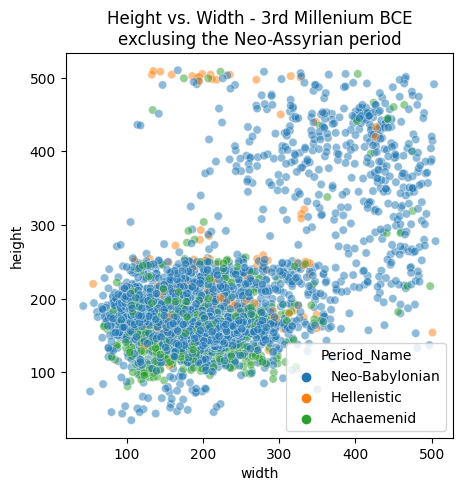

In [35]:
plt.figure(figsize=(5, 5))
sns.scatterplot(y='height', x ='width', hue='Period_Name', data=ratio_df[(ratio_df["millennium"]=='1st millennium BCE')&~(ratio_df["Period_Name"].isin(['other', 'Neo-Assyrian']))], alpha = 0.5)
plt.title("Height vs. Width - 3rd Millenium BCE\nexclusing the Neo-Assyrian period")
plt.show()

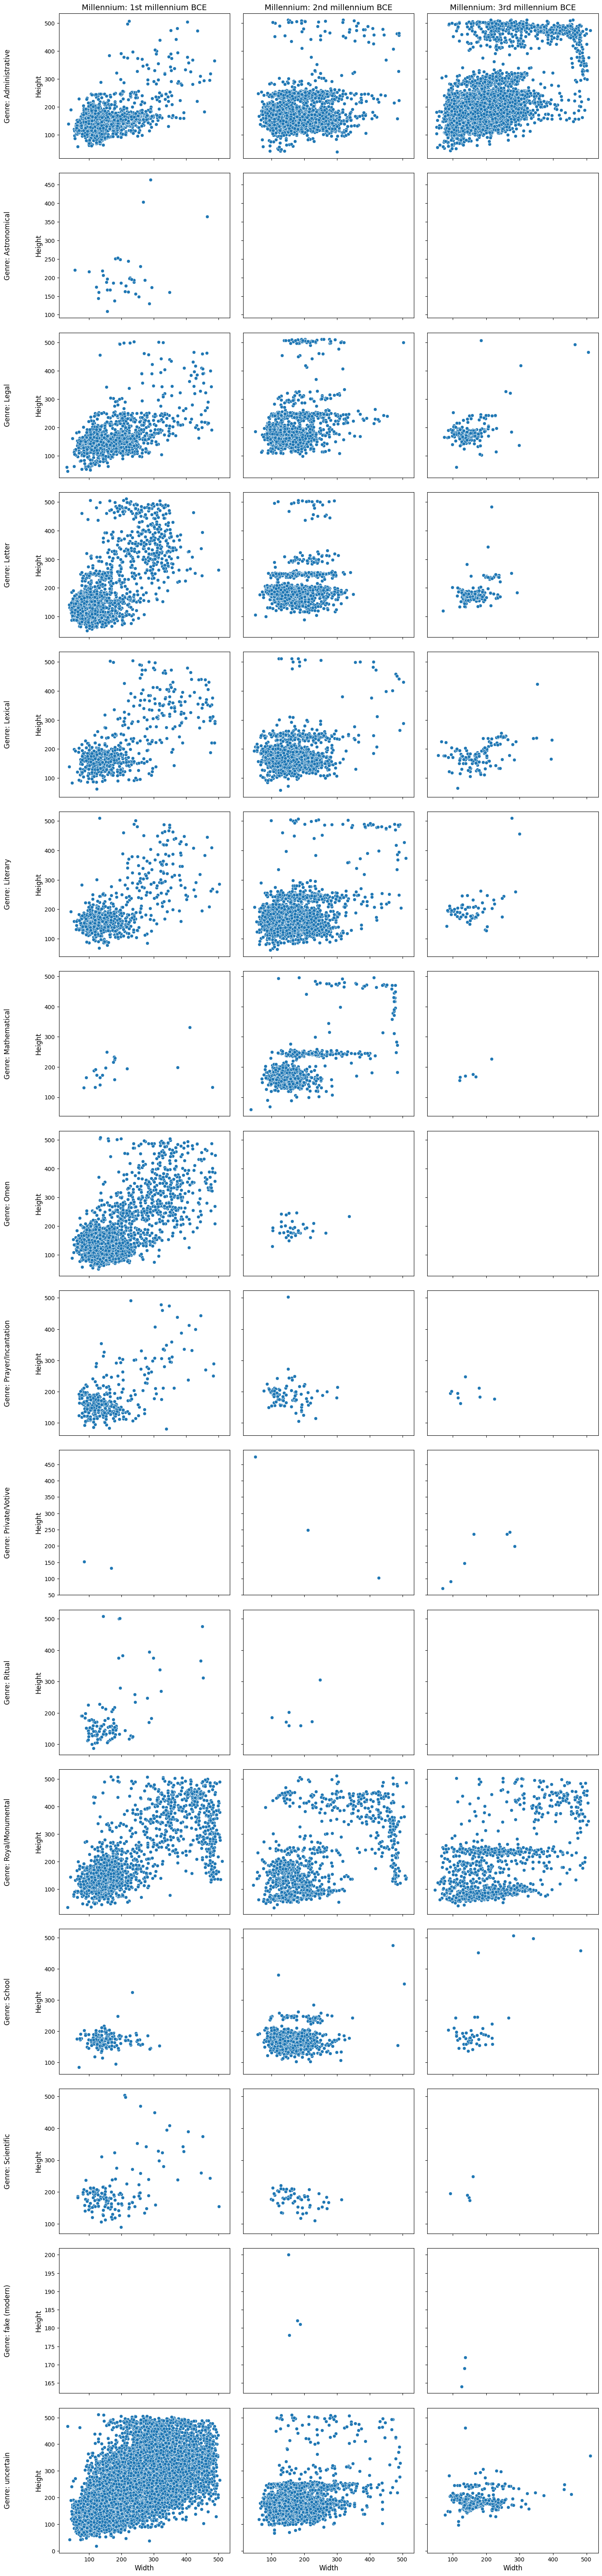

In [36]:
max_cols = 3  # One column for each millennium

unique_genres = sorted(ratio_df["Period_Name"].unique())

n_rows = len(unique_genres)

fig_width = max_cols * 5  # Decrease width for smaller plots
fig_height = n_rows * 4  # Decrease height accordingly
fig, axes = plt.subplots(n_rows, max_cols, figsize=(fig_width, fig_height), sharex='col', sharey='row')

# Ensure axes is a 2D array even if there's only one row
if n_rows == 1:
    axes = np.array([axes])

# Labeling and plotting for each subplot
for i, genre in enumerate(unique_genres):
    for j, millennium in enumerate(sorted(ratio_df["millennium"].unique())):
        ax = axes[i, j]
        df_filtered = ratio_df[(ratio_df["millennium"] == millennium) & (ratio_df["Genre_Name"] == genre)]
        
        sns.scatterplot(x='width', y='height', data=df_filtered, ax=ax)
        
        if i == 0:
            ax.set_title(f'Millennium: {millennium}', fontsize=14)
        if j == 0:
            ax.text(-0.3, 0.5, f'Genre: {genre}', fontsize=12, rotation=90,
                    ha='center', va='center', transform=ax.transAxes)

        if i == n_rows - 1:
            ax.set_xlabel('Width', fontsize=12)
        if j == 0:
            ax.set_ylabel('Height', fontsize=12)

plt.tight_layout(pad=2.0)

plt.show()


In [149]:
X_train, X_test, y_train, y_test = train_test_split(ratio_df[['hw_ratio']], ratio_df['period'], test_size=500, random_state=0)
print(X_train.shape, X_test.shape)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
preds = rf.predict(X_test)

(93436, 1) (500, 1)


In [150]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.46      0.69      0.55       150
           2       0.32      0.64      0.43       118
           3       0.24      0.10      0.14        78
           4       0.00      0.00      0.00        38
           5       0.00      0.00      0.00        30
           6       0.00      0.00      0.00        14
           7       0.00      0.00      0.00         8
           8       0.00      0.00      0.00        15
           9       0.00      0.00      0.00         6
          10       0.00      0.00      0.00        12
          11       0.00      0.00      0.00         7
          12       0.00      0.00      0.00         2
          13       0.00      0.00      0.00         5
          14       0.00      0.00      0.00         1
          15       0.00      0.00      0.00         2
          16       0.00      0.00      0.00         6
          17       0.00    

/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [151]:
EARLY_BRONZE = {
    'Old Akkadian', 'Ur III',
    'ED IIIb', 'Uruk III',
    'Proto-Elamite', 'Lagash II',
    'Ebla', 'ED IIIa', 'ED I-II',
    'Uruk IV', 'Linear Elamite',
    'Harappan'
}
MID_LATE_BRONZE = {
    'Early Old Babylonian',
    'Old Babylonian', 'Old Assyrian',
    'Middle Babylonian', 'Middle Assyrian',
    'Middle Elamite', 'Middle Hittite'
}
IRON = {
    'Neo-Babylonian', 'Neo-Assyrian',
    'Achaemenid', 'Hellenistic',
    'Neo-Elamite'
}
ERA_MAP = {
    **{K: 'EB' for K in EARLY_BRONZE},
    **{K: 'MLB' for K in MID_LATE_BRONZE},
    **{K: 'I' for K in IRON},
}

In [152]:
def explain(period):
    return f'{period} ({ERA_MAP.get(period, "?")})'

In [153]:
idx2period = {v: k for k, v in TabletPeriodDataset.PERIOD_INDICES.items()}
idx2period[0] = 'other'

In [154]:
# let's just use classes with support >=10, everything else goes to 0: other
COMMON_LABELS = list({k for k, v in Counter(y_test).items() if v >= 10})
print(f'Common labels: ({len(COMMON_LABELS)})')
[(i, explain(idx2period[i])) for i in COMMON_LABELS]

Common labels: (8)


[(1, 'Ur III (EB)'),
 (2, 'Neo-Assyrian (I)'),
 (3, 'Old Babylonian (MLB)'),
 (4, 'Middle Babylonian (MLB)'),
 (5, 'Neo-Babylonian (I)'),
 (6, 'Old Akkadian (EB)'),
 (8, 'Early Old Babylonian (MLB)'),
 (10, 'Middle Assyrian (MLB)')]

In [155]:
y_true_c = y_test.copy()
y_true_c[~np.isin(y_test, COMMON_LABELS)] = 0
print((~np.isin(y_test, COMMON_LABELS)).mean(), 'changed to "other"')

0.09 changed to "other"


In [156]:
y_pred_c = preds.copy()
y_pred_c[~np.isin(preds, COMMON_LABELS)] = 0
print((~np.isin(preds, COMMON_LABELS)).mean(), 'changed to "other"')

0.008 changed to "other"


In [157]:
indices_c = list(set(y_true_c) | set(y_pred_c))
print(len(indices_c))
print(indices_c)
PERIOD_LABELS_C = [explain(idx2period[i]) for i in indices_c]
print(PERIOD_LABELS_C)

9
[0, 1, 2, 3, 4, 5, 6, 8, 10]
['other (?)', 'Ur III (EB)', 'Neo-Assyrian (I)', 'Old Babylonian (MLB)', 'Middle Babylonian (MLB)', 'Neo-Babylonian (I)', 'Old Akkadian (EB)', 'Early Old Babylonian (MLB)', 'Middle Assyrian (MLB)']


In [158]:
print(classification_report(y_true_c, y_pred_c, target_names=PERIOD_LABELS_C))

                            precision    recall  f1-score   support

                 other (?)       0.00      0.00      0.00        45
               Ur III (EB)       0.46      0.69      0.55       150
          Neo-Assyrian (I)       0.32      0.64      0.43       118
      Old Babylonian (MLB)       0.24      0.10      0.14        78
   Middle Babylonian (MLB)       0.00      0.00      0.00        38
        Neo-Babylonian (I)       0.00      0.00      0.00        30
         Old Akkadian (EB)       0.00      0.00      0.00        14
Early Old Babylonian (MLB)       0.00      0.00      0.00        15
     Middle Assyrian (MLB)       0.00      0.00      0.00        12

                  accuracy                           0.38       500
                 macro avg       0.11      0.16      0.13       500
              weighted avg       0.25      0.38      0.29       500



/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kapond/.conda/envs/dani_torch/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [141]:
def period_to_millennium(period):
    if period in ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                                                                         'Ur III']:
        return "3rd millennium BCE"
    elif period in ['Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                                                                        'Middle Babylonian', 'Middle Elamite', 'Middle Hittite']:
        return "2nd millennium BCE"
    else:
        return "1st millennium BCE"

# Apply the function to the 'period' column to create a new 'millennium' column
df['millennium'] = df['period_normed'].apply(period_to_millennium)

In [63]:
df.loc[df['height']=='?', 'height'] = np.nan
df.loc[df['width']=='?', 'width'] = np.nan
df.loc[df['thickness']=='?', 'thickness'] = np.nan

In [82]:
df['height']=pd.to_numeric(df['height'], errors='coerce')
df['width']=pd.to_numeric(df['width'], errors='coerce')
df['thickness']=pd.to_numeric(df['thickness'], errors='coerce')

In [85]:
df['h_w_ratio']=df['height']/df['width']

In [101]:
set(df[df['h_w_ratio']<100].dropna(subset=['height'])['period_normed'])

{'ED I-II',
 'ED IIIa',
 'ED IIIb',
 'Early Old Babylonian',
 'Ebla',
 'Lagash II',
 'Middle Assyrian',
 'Middle Babylonian',
 'Middle Elamite',
 'Middle Hittite',
 'Neo-Assyrian',
 'Neo-Babylonian',
 'Old Akkadian',
 'Old Assyrian',
 'Old Babylonian',
 'Proto-Elamite',
 'Ur III',
 'Uruk III',
 'Uruk IV'}

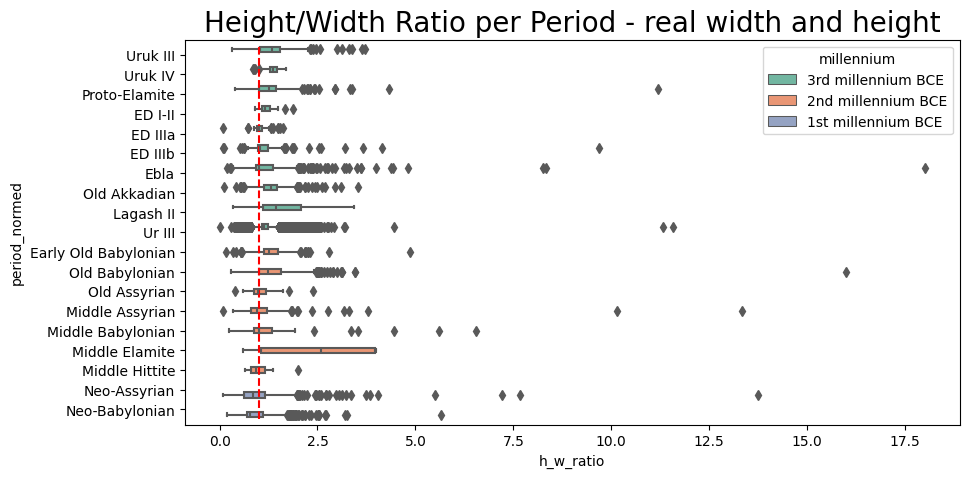

In [105]:
plt.figure(figsize=(10,5))

period_order = ['Uruk III', 'Uruk IV', 'Proto-Elamite', 'ED I-II', 'ED IIIa', 'ED IIIb', 'Ebla', 'Old Akkadian', 'Lagash II', 
                'Ur III', 'Early Old Babylonian', 'Old Babylonian', 'Old Assyrian', 'Middle Assyrian', 
                'Middle Babylonian', 'Middle Elamite', 'Middle Hittite', 'Neo-Assyrian', 
                'Neo-Babylonian']# 'Achaemenid', 'Hellenistic']

period_index = {period: i for i, period in enumerate(period_order)}
df['Period_Index'] = df['period_normed'].map(period_index)

box_p = sns.boxplot(y='period_normed', x='h_w_ratio', data=df[df['h_w_ratio']<100].dropna(subset=['height']), hue='millennium',
                    order=period_order, palette="Set2")

left, right = plt.ylim()
plt.title('Height/Width Ratio per Period - real width and height', size=20)
plt.vlines([1], ymin=left, ymax=right, color='r', linestyles='--')

plt.show()
